In [8]:
from ultralytics import YOLO
import cv2

import util
from util import get_car, read_license_plate, write_csv
import numpy as np
import os
import glob
import torch
from easyocr import Reader
from ultralytics.utils.plotting import Annotator
import pytesseract

#from paddleocr import PaddleOCR,draw_ocr

import re


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


## Tratamiento de imagenes
import cv2


In [9]:
from matplotlib import pyplot as plt


In [10]:
def resize_image_to_dpi(image, dpi=300):
    # Calculate the target width and height for the desired DPI
    width_inch = image.shape[1] / dpi
    height_inch = image.shape[0] / dpi
    target_width = int(width_inch * 300)  # 300 DPI
    target_height = int(height_inch * 300)  # 300 DPI

    # Resize the image to the calculated dimensions
    resized_image = cv2.resize(image, (target_width, target_height))
    return resized_image

def apply_adaptive_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresholded

def apply_otsu_binarization(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def remove_noise(image):
    denoised = cv2.GaussianBlur(image, (5, 5), 0)
    return denoised

def apply_morphology(image):
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(image, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded

def deskew_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    angle = cv2.minAreaRect(contour)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return rotated

def add_border(image, border_size=10, white=True):
    # Verificar si la imagen es en escala de grises
    if len(image.shape) == 2:
        # Convertir la imagen en escala de grises a una imagen en color (escala de grises replicada en cada canal)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    if white:
        # Agregar un borde blanco a la imagen en color
        bordered = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                    cv2.BORDER_CONSTANT, value=(255, 255, 255))  # White border
    else:
        bordered = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                    cv2.BORDER_CONSTANT, value=(0, 0, 0))  # Black border
    
    target_height = image.shape[0]
    target_width = image.shape[1]
    resized_image = cv2.resize(bordered, (target_width, target_height))
    
    return resized_image


# Función para convertir una imagen en escala de grises a color
def gray_to_color(image):
    return cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image



def detect_horizontal_lines(image, original_image):

    result_image = original_image.copy()

    # Convertir la imagen a escala de grises si es necesario
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # La imagen ya es una escala de grises
    
    # Aplicar suavizado para reducir el ruido
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detectar bordes usando Canny
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    
    # Aplicar transformada de Hough para detectar líneas
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 60, 50, 10, maxLineGap=5)

    horizontal_lines = []

        # Filtrar líneas horizontales basadas en la pendiente
    if lines is None:
        print("No se detectaron líneas horizontales.")
        return [], None  # Devolver una lista vacía si no se detectaron líneas
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 60 and abs(x2-x1) > 10:  # Considerar líneas casi horizontales (umbral ajustable)
            horizontal_lines.append(line)
            cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dibujar la línea sobre la imagen original

    
    return horizontal_lines, result_image

def calculate_angle_of_inclination(horizontal_lines):
    # Calcular el ángulo de inclinación promedio de las líneas horizontales
    angles = []
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]

        # (y2-y1)/(x2-x1) es la forma de calcular la pendiente de la recta,
        # una vez calculada calculamos la arcotangente para obtener el angulo de inclinacion
        angle_rad = np.arctan2(y2 - y1, x2 - x1)
        angle_deg = np.degrees(angle_rad)
        angles.append(angle_deg)
    
    # Calcular el ángulo promedio
    if angles:
        average_angle = np.mean(angles)
    else:
        average_angle = 0.0
    
    return average_angle

def correct_perspective(image, angle_of_inclination):
    # Obtener dimensiones de la imagen
    h, w = image.shape[:2]
    
    # Calcular la matriz de transformación de perspectiva para enderezar la imagen
    rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), -angle_of_inclination, 1.0)
    corrected_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    
    return corrected_image

def centered_license_plate(license_plate_ROI):

    license_plate = license_plate_ROI.copy()
    # Resize to minimum 300 DPI
    resized_image = resize_image_to_dpi(license_plate)

    # Apply adaptive thresholding
    #thresholded_image = apply_adaptive_threshold(resized_image)

    # Apply Otsu's binarization
    thresholded_image = apply_otsu_binarization(resized_image)

    # Remove noise
    denoised_image = remove_noise(thresholded_image)

    # Apply dilation and erosion
    processed_image = apply_morphology(denoised_image)

    # Rotate / Deskew the image
    #rotated_image = deskew_image(processed_image)
    
    # Calcula la mediana de la intensidad de los gradientes
    median_intensity = np.median(processed_image)
    
    # Define los umbrales bajo y alto adaptativos basados en la mediana
    lower_threshold = float(max(0, (1.0 - 0.33) * median_intensity))
    upper_threshold = float(min(255, (1.0 + 0.33) * median_intensity))
    
    # Aplica el detector de bordes Canny con los umbrales adaptativos
    edges = cv2.Canny(thresholded_image, lower_threshold, upper_threshold)
    # Detectar líneas horizontales en la placa de matrícula
    horizontal_lines, imagen_lineas_h = detect_horizontal_lines(edges, resized_image)

    # Calcular el ángulo de inclinación promedio de las líneas horizontales
    if np.size(horizontal_lines) != 0:

        angle_of_inclination = calculate_angle_of_inclination(horizontal_lines)

        # Corregir la perspectiva de la placa de matrícula basada en el ángulo de inclinación
        corrected_plate_image = correct_perspective(license_plate_ROI, -angle_of_inclination)
    else:
        corrected_plate_image = license_plate_ROI


    return corrected_plate_image

def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()


image 1/1 d:\00. Documentos D\Programacion\TFG\datasets\baza_slika\040603\P1010002.jpg: 480x640 2 cars, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
0.8856738805770874
0.8470960855484009

0: 640x320 (no detections), 188.0ms
Speed: 1.0ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


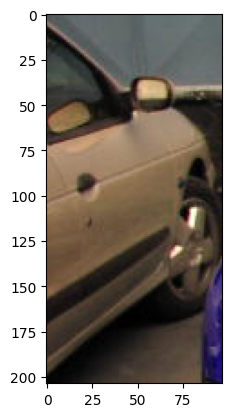

In [11]:
coco_model = YOLO('yolov8n.pt')
license_plate_detector = YOLO('./models/license_plate_detector.pt')
ocr_model = YOLO('./models/ocr.pt')


cwd = os.getcwd()

#path = cwd+"\\datasets\\validation\\2bf9f8b8-0827-49f5-81d0-5affe1cce1cf.jpg"
#path = cwd+"\\datasets\\validation\\20664ebe-baca-4eb7-adea-a6b5929123a9.jpg"
#path = cwd+"\\datasets\\validation\\IMG_8220.JPEG"
path = "./datasets/baza_slika/040603/P1010002.jpg"
#path = cwd+"\\datasets\\validation\\IMG_8881.JPEG"
#path = cwd+"\\datasets\\validation\\IMG_8847.JPEG"
#path = cwd+"\\datasets\\validation\\IMG_8880.JPEG"
# En este ultimo detecta dos coches y el de mayor score es el que no tiene placa, esto pasa con varios, tener cuidado

# Supongamos que solo estamos interesados en las cajas delimitadoras con una confianza mayor que un umbral
confianza_umbral = 0.5
coordenadas_cajas = []

#print(predictions)
vehicles = [2,3,5,7]

threshold = 70

## Declaracion inicial easyocr
reader = Reader(lang_list=["es"], gpu=True)


detections = coco_model(path, verbose=True, classes=vehicles, conf=0.7)[0]
detections_ = []

#detections.save_crop(save_dir='.\\datasets\\validation\\car_detection', file_name=f'image{i}')

detections = detections.boxes.data.tolist()

best_detection = None

best_car_detection = 0.0

for detection in detections:
    x1, y1, x2, y2, score, class_id = detection

    if score > best_car_detection:
        
        best_detection = detection
        
        best_car_detection = score
        


x1, y1, x2, y2, score, class_id = best_detection


if int(class_id) in vehicles:
    
    img = cv2.imread(path)
    image_crop = img[int(y1):int(y2), int(x1): int(x2)]
    
    lp_predictions = license_plate_detector.predict(source=image_crop, device='cuda')[0]

    #lp_predictions.save(f'.//license_plate_predictions//img{index_file_predict}.jpg')
    #cv2.imshow("Coche detectado", image_crop)
    plt.imshow(image_crop)
    best_score = 0

    for detection in lp_predictions.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection

        if score > best_score:

            license_plate_ROI = image_crop[int(y1):int(y2),int(x1):int(x2)]

            license_plate_ROI_save = license_plate_ROI

            best_score = score

            plt.imshow(license_plate_ROI)


In [12]:
thresholded_image = apply_otsu_binarization(license_plate_ROI_save)

plt.imshow(gray_to_color(thresholded_image))


NameError: name 'license_plate_ROI_save' is not defined

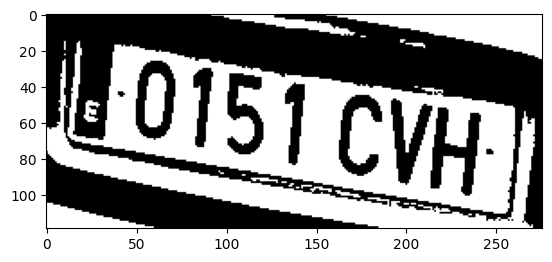

In [ ]:
gray=cv2.bilateralFilter(thresholded_image,11,17,17)
plt.imshow(gray_to_color(gray))


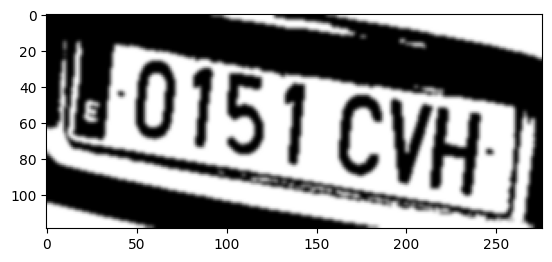

In [ ]:
# Remove noise
denoised_image = remove_noise(thresholded_image)
plt.imshow(gray_to_color(denoised_image))


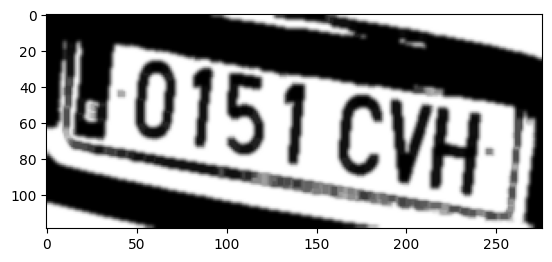

In [ ]:
# Apply dilation and erosion
processed_image = apply_morphology(denoised_image)
plt.imshow(gray_to_color(processed_image))


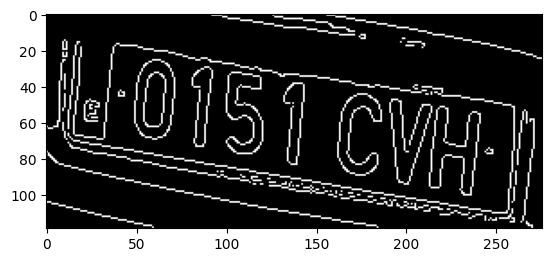

In [ ]:
# Calcula la mediana de la intensidad de los gradientes
median_intensity = np.median(processed_image)
    
# Define los umbrales bajo y alto adaptativos basados en la mediana
lower_threshold = float(max(0, (1.0 - 0.33) * median_intensity))
upper_threshold = float(min(255, (1.0 + 0.33) * median_intensity))
    
# Aplica el detector de bordes Canny con los umbrales adaptativos
edges = cv2.Canny(thresholded_image, lower_threshold, upper_threshold) 

plt.imshow(gray_to_color(edges))


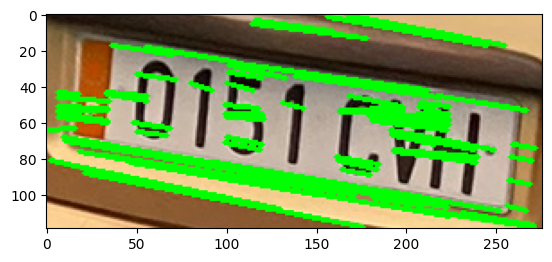

In [ ]:
# Detectar líneas horizontales en la placa de matrícula
horizontal_lines, imagen_lineas_h = detect_horizontal_lines(edges, license_plate_ROI_save)

plt.imshow(gray_to_color(imagen_lineas_h))

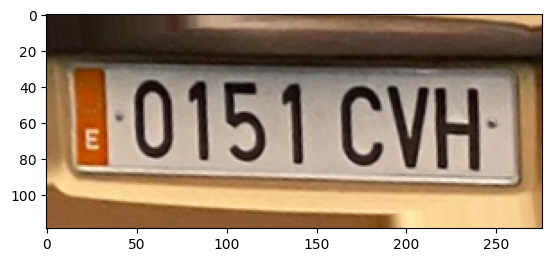

In [ ]:
# Calcular el ángulo de inclinación promedio de las líneas horizontales
if np.size(horizontal_lines) != 0:

    angle_of_inclination = calculate_angle_of_inclination(horizontal_lines)

    # Corregir la perspectiva de la placa de matrícula basada en el ángulo de inclinación
    corrected_plate_image = correct_perspective(license_plate_ROI, -angle_of_inclination)
else:
    corrected_plate_image = license_plate_ROI

plt.imshow(corrected_plate_image)

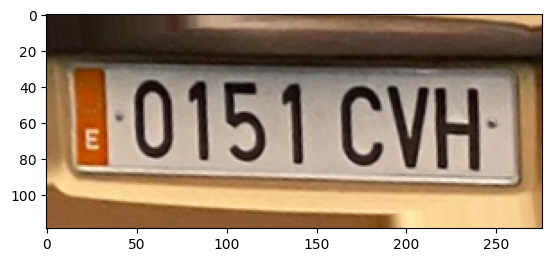

In [ ]:
horizontal_license_plate = centered_license_plate(license_plate_ROI_save)
plt.imshow(horizontal_license_plate)

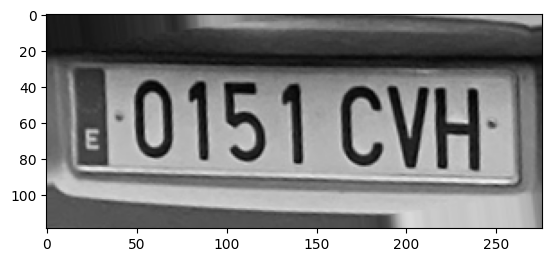

In [ ]:
import imutils

image = horizontal_license_plate.copy()

#now we will convert image to gray scale
#why we do is because it will reduce the dimension , also reduces complexity of image
#and yeah there are few algorithms like canny , etc which only works on grayscale images
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_to_color(gray))
#cv2.waitKey(0)



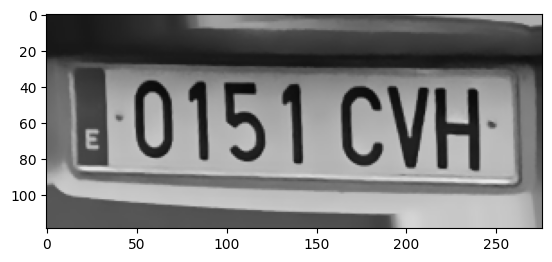

In [ ]:
#now we will reduce noise from our image and make it smooth
gray=cv2.bilateralFilter(gray,11,17,17)
plt.imshow(gray_to_color(gray))
#cv2.waitKey(0)



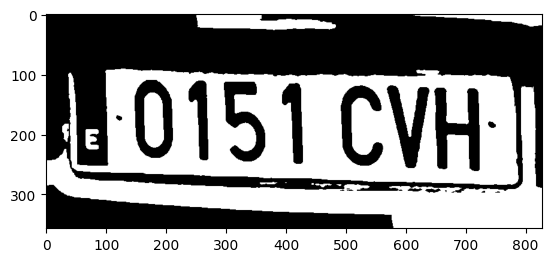

In [ ]:
resize_image = cv2.resize(gray, None, fx = 3, fy= 3, interpolation = cv2.INTER_CUBIC)

#blured_image = cv2.GaussianBlur(resize_image, (5,5), 0)

ret, thresh = cv2.threshold(resize_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)

plt.imshow(gray_to_color(thresh))

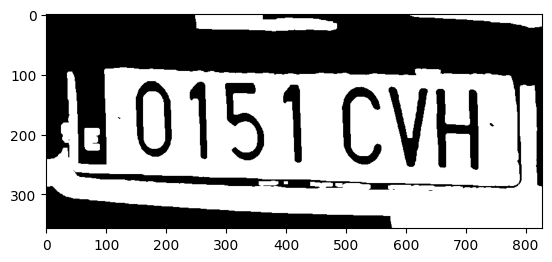

In [ ]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

dilation = cv2.dilate(thresh, rect_kern, iterations = 1)

plt.imshow(gray_to_color(dilation))

In [ ]:
cnts, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
'''#now we will find the edges of images
edged=cv2.Canny(gray,170,200)
plt.imshow(gray_to_color(edged))
#cv2.waitKey(0)'''



'#now we will find the edges of images\nedged=cv2.Canny(gray,170,200)\nplt.imshow(gray_to_color(edged))\n#cv2.waitKey(0)'

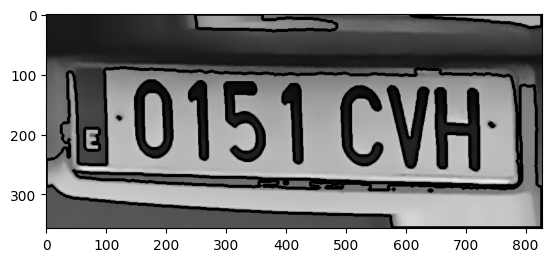

In [ ]:
'''#now we will find the contours based on the images.
cnts,new=cv2.findContours(edged.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)'''
#so here cnts is contours which means that it is like the curve joining all the contiour points
#new is heirarchy-relationship
#RETR_LIST - it retrives all the contours but doesn't create any parent-child relationship
#CHAIN_APPROX_SIMPLE - it removes all the redundant points and compress the contour by saving memory

#we will create a copy of our original image to draw all the contours
image1=resize_image.copy()
cv2.drawContours(image1,cnts,-1,(0,255,0),3)
plt.imshow(gray_to_color(image1))
#cv2.waitKey(0)



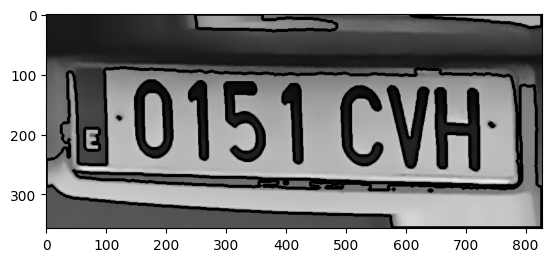

In [ ]:
#now we don't want all the contours we are intrested only in number plate
#but can't directly locate that so we will sort them on the basic of their areas
#we will select those area which are maximum so we will select top 30 areas
#but it will give sorted list as in order of min to maximum
#so for that we will reverse the order of sorting

cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
NumberPlateCount=None

#to drow top 30 contours we will make copy of original image and use
image2=resize_image.copy()
cv2.drawContours(image2,cnts,-1,(0,255,0),3)
plt.imshow(gray_to_color(image2))
#cv2.waitKey(0)


In [ ]:
def calculate_bounds(roi):
    x, y, width, height = cv2.boundingRect(roi)
    x_min = x
    y_min = y
    x_max = x + width
    y_max = y + height
    return (x_min, y_min, x_max, y_max)


def is_roi_contained(roi_inner, roi_outer):
    x_min_inner, y_min_inner, x_max_inner, y_max_inner = calculate_bounds(roi_inner)
    x_min_outer, y_min_outer, x_max_outer, y_max_outer = calculate_bounds(roi_outer)

    # Comprobar si el ROI interno está completamente dentro del ROI externo
    return (x_min_inner >= x_min_outer and
            y_min_inner >= y_min_outer and
            x_max_inner <= x_max_outer and
            y_max_inner <= y_max_outer)

7936
3552
4061
8777
4356
8976
9248
10001


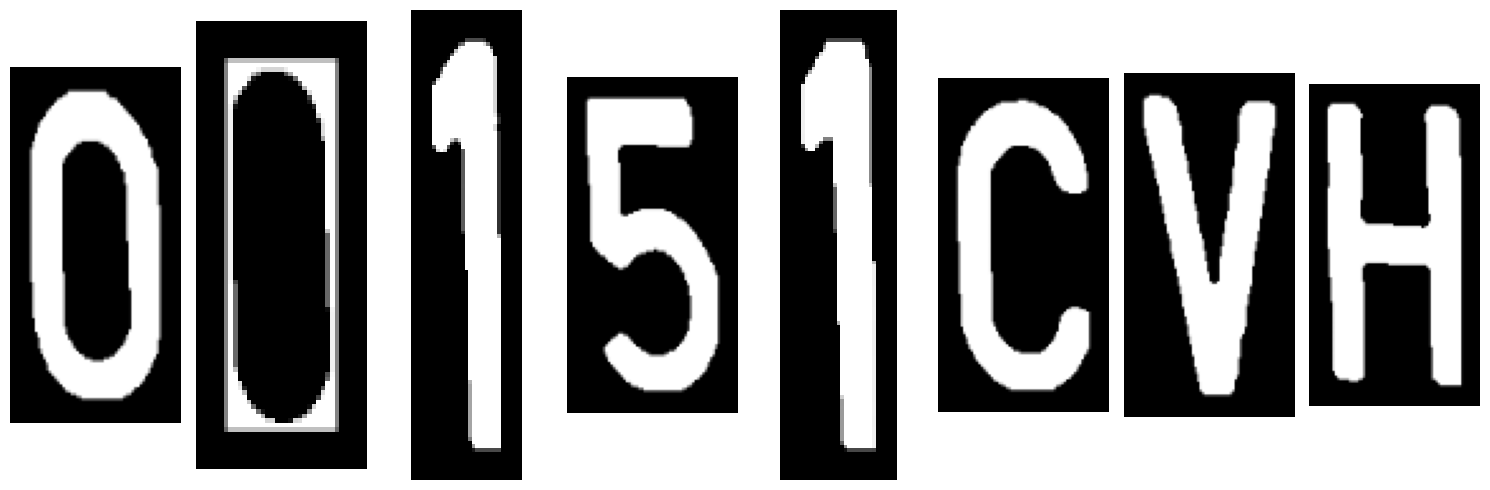

In [ ]:
sorted_contours = sorted(cnts, key = lambda ctr: cv2.boundingRect(ctr)[0])

list_of_rois = []

x_anterior, y_anterior, w_anterior, h_anterior = 0,0,0,0

license_plate_contours = []

for cnt in sorted_contours:

    roi = None

    x,y,w,h = cv2.boundingRect(cnt)

    height, width = image2.shape

    if height / float(h) > 6: continue

    ratio = h/float(w)

    #if ratio < 1: continue
    if w > 300: continue

    #if w < 20 or h < 20: continue

    area = h * w

    #if area < 5000: continue
    print(area)
    roi = thresh[y-1: y+h, x:x+w]

    roi = cv2.bitwise_not(roi)

    license_plate_contours.append(cnt)

    
    list_of_rois.append(gray_to_color(add_border(roi, white=False)))
    
    #plt.imshow(gray_to_color(roi))

# Configurar la cuadrícula de subplots

filas = 1
columnas = len(list_of_rois)
fig, axs = plt.subplots(filas, columnas, figsize=(15, 5))  # Ajusta el tamaño según sea necesario

# Iterar sobre cada imagen y mostrarla en un subplot
for i, imagen in enumerate(list_of_rois):
    # Mostrar la imagen en el subplot correspondiente
    axs[i].imshow(imagen)
    axs[i].axis('off')  # Deshabilitar los ejes

    # Opcional: Agregar un título a cada subplot
    # axs[i].set_title(f'Imagen {i+1}')  # Puedes personalizar el título

# Mostrar todas las imágenes
plt.tight_layout()  # Ajustar el diseño para que no se superpongan los subplots
plt.show()

In [ ]:
license_plate_number = ""

for roi in list_of_rois:
    ocr_results = reader.readtext(roi)

    for (bbox, text, prob) in ocr_results:
        # display the OCR'd text and associated probability
        print("[INFO] {:.4f}: {}".format(prob, text))

        # cleanup the text and draw the box surrounding the text along
        # with the OCR'd text itself
        clean_text = cleanup_text(text)

        license_plate_number += text

print(license_plate_number)

[INFO] 0.9997: 0
[INFO] 0.9422: 1
[INFO] 1.0000: 5
[INFO] 0.8983: 1
[INFO] 0.9392: C
[INFO] 0.9245: V
[INFO] 0.8044: H
0151CVH


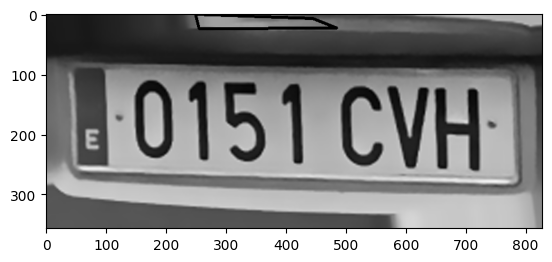

In [ ]:
image3 = resize_image.copy()
#now we will run a for loop on our contours to find the best possible contour of our expectes number plate
count=0
name=1  #name of our cropped image

for i in cnts:
    perimeter=cv2.arcLength(i,True)
    #perimeter is also called as arcLength and we can find directly in python using arcLength function
    approx=cv2.approxPolyDP(i,0.02*perimeter,True)
    #approxPolyDP we have used because it approximates the curve of polygon with the precision
    if(len(approx)==4):  # 4 means it has 4 corner which well be most probably our number plate as it also has 4 corners
        NumberPlateCount=approx
        #now we will crop that rectangle part
        x , y , w , h =cv2.boundingRect(i)
        crp_img=image3[y:y+h,x:x+w]
        #cv2.imwrite(str(name)+'.png',crp_img)
        name+=1

        break

#now we will draw contour in our main image that we have identified as a number plate
cv2.drawContours(image3,[NumberPlateCount],-1,(0,255,0),3)
plt.imshow(gray_to_color(image3))
#cv2.waitKey(0)


In [ ]:
ocr_results = reader.readtext(dilation)

for (bbox, text, prob) in ocr_results:
    # display the OCR'd text and associated probability
    print("[INFO] {:.4f}: {}".format(prob, text))

    # cleanup the text and draw the box surrounding the text along
    # with the OCR'd text itself
    clean_text = cleanup_text(text)

[INFO] 0.7186: 0151 CVh


In [ ]:
#now what we do is by using pytesseract module we will convert our image into text
text_tess = pytesseract.image_to_string(image, lang='eng', config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ —psm 8 —oem 3')

#text_tess=pytesseract.image_to_string(image,lang='eng')
text_tess = ''.join(e for e in text_tess if e.isalnum())  #modify our text no spaces
print("License plate number is : ",text_tess)


License plate number is :  TOTSTCVH


In [ ]:
def transformar_id_a_alfabeto(class_id):
    names = {
        0.0: '0',
        1.0: '1',
        2.0: '2',
        3.0: '3',
        4.0: '4',
        5.0: '5', 
        6.0: '6', 
        7.0: '7', 
        8.0: '8', 
        9.0: '9', 
        10.0: 'A', 
        11.0: 'B', 
        12.0: 'C', 
        13.0: 'D', 
        14.0: 'E', 
        15.0: 'F', 
        16.0: 'G', 
        17.0: 'H', 
        18.0: 'I', 
        19.0: 'J', 
        20.0: 'K', 
        21.0: 'L', 
        22.0: 'M', 
        23.0: 'N', 
        24.0: 'O', 
        25.0: 'P', 
        26.0: 'Q', 
        27.0: 'R', 
        28.0: 'S', 
        29.0: 'T', 
        30.0: 'U', 
        31.0: 'V', 
        32.0: 'W', 
        33.0: 'X', 
        34.0: 'Y', 
        35.0: 'Z'
        }
    
    return names[class_id]


In [ ]:
ocr = ocr_model.predict(source=gray_to_color(dilation), device='cuda')[0]

license_plate_text = ""

for detection in ocr.boxes.data.tolist():
    _,_,_,_, score, class_id = detection

    caracter = transformar_id_a_alfabeto(class_id)

    license_plate_text += caracter



print(f'Desordenado: {license_plate_text}')


0: 288x640 1 0, 2 1s, 1 4, 1 5, 1 C, 1 H, 1 T, 1 V, 1 Y, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Desordenado: H5011VCTY4


In [ ]:
from imutils.object_detection import non_max_suppression

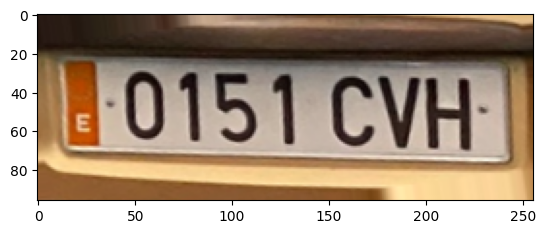

In [ ]:
(H, W) = image.shape[:2]

layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
net = cv2.dnn.readNet(".\\models\\frozen_east_text_detection.pb")

(newW, newH) = ((W // 32) * 32, (H // 32) * 32)
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

min_confidence = 0.6

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
	
	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < min_confidence:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])
		

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * newW)
	startY = int(startY * newH)
	endX = int(endX * newW)
	endY = int(endY * newH)
	# draw the bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
plt.imshow(image)

In [ ]:
import matplotlib.pyplot as plt

import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = [
    keras_ocr.tools.read(url) for url in [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/e/e8/FseeG2QeLXo.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg'
    ]
]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

: 

In [ ]:
import keras_ocr
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(image)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(image), figsize=(20, 20))
for ax, image, predictions in zip(axs, image, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

plt.show()

Looking for C:\Users\José Manuel\.keras-ocr\craft_mlt_25k.h5



ValueError: Unrecognized keyword arguments passed to Dense: {'weights': [array([[          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0]], dtype=float32), array([          1,           0,           0,           0,           1,           0], dtype=float32)]}